In [ ]:
!pip install clickhouse-driver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.3 MB/s eta 0:00:00


In [ ]:
from clickhouse_driver import Client
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace import exponential_smoothing
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# Task 1

## A) Write an SQL query

In [ ]:
CLICKHOUSE_HOST = '37.59.22.112'
CLICKHOUSE_PORT = '9000'
CLICKHOUSE_USER = 'lrunjic'
CLICKHOUSE_PASSWORD = 'frB210Ajo88Y8H9afHv5'
CLICKHOUSE_DATABASE = 'lrunjic'

In [ ]:
client = Client(
                host=CLICKHOUSE_HOST,
                port=CLICKHOUSE_PORT,
                user=CLICKHOUSE_USER,
                password=CLICKHOUSE_PASSWORD,
                database=CLICKHOUSE_DATABASE
            )

In [ ]:
query = """  WITH user_event_counts AS (
                SELECT
                    bqe.user_pseudo_id,
                    bqe.event_date AS ev_date,
                    COUNT(DISTINCT bqe.id) AS events_per_user
                FROM bq.events bqe
                JOIN sports.event se ON bqe.id = se.id
                JOIN sports.sport ss ON se.sport_id = ss.id
                WHERE bqe.event_date BETWEEN '20240101' AND '20240530'
                  AND bqe.platform = 'IOS'
                  AND bqe.geo_country = 'Croatia'
                  AND ss.name = 'Football'
                GROUP BY bqe.user_pseudo_id, bqe.event_date
            )
            SELECT
              ev_date,
              AVG(events_per_user) AS avg_events_per_user
            FROM user_event_counts
            GROUP BY ev_date
            ORDER BY ev_date;

       """

## B) Load the dataset

In [ ]:
result = client.execute(query)

In [ ]:
df = pd.DataFrame(result, columns=['ev_date', 'avg_events_per_user'])
df.head(5)

,ev_date,avg_events_per_user
0,20240101,2.721652
1,20240102,3.535948
2,20240103,3.687455
3,20240104,3.480535
4,20240105,3.895940


I used a 7-day moving average to smooth out the weekly ups and downs in the data. The dataset isn’t very long, so a bigger window would hide too much, while a smaller one wouldn’t give a clear picture of the trend.

In [ ]:
df['ev_date'] = pd.to_datetime(df['ev_date']) # convert column to datetime to enable proper handling of dates and times
df = df.sort_values('ev_date') # sort the data in chronological order

In [ ]:
window_sizes = [3, 7, 14]

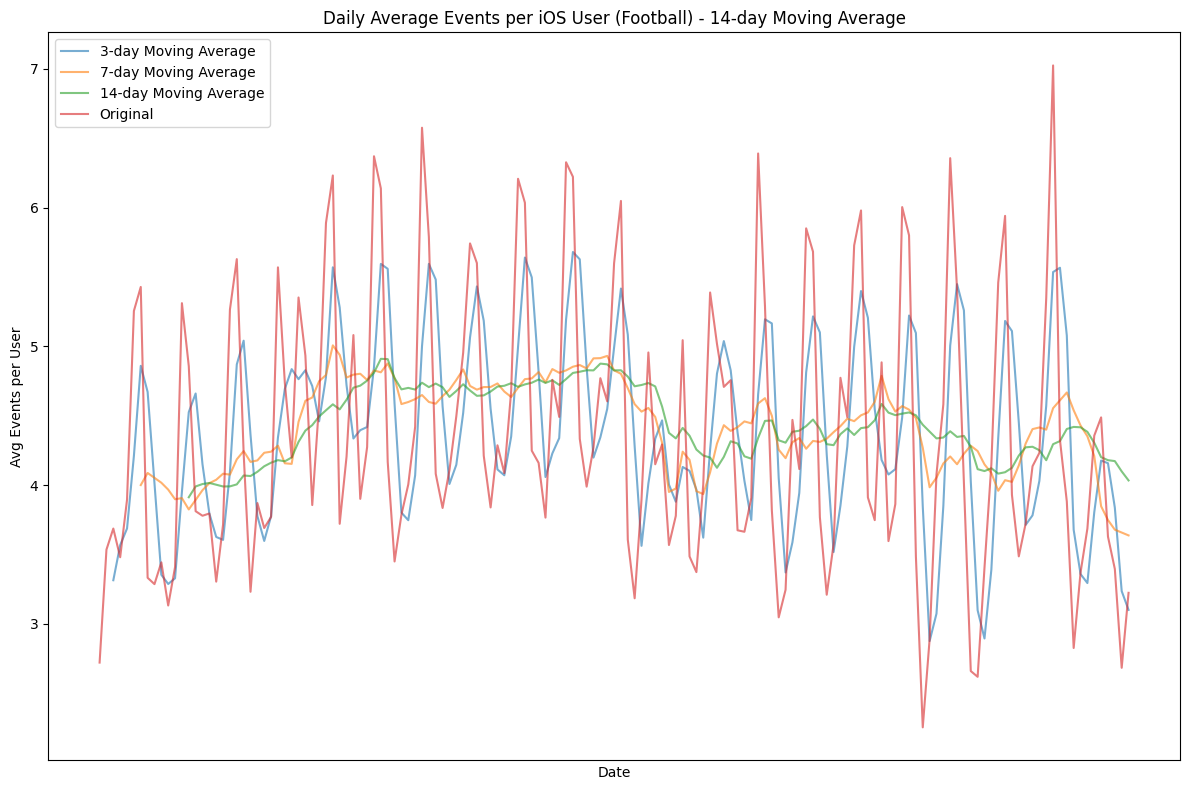

In [ ]:
plt.figure(figsize=(12, 8))
for window_size in window_sizes:
    df[f'moving_avg_{window_size}'] = df['avg_events_per_user'].rolling(window=window_size).mean()
    plt.plot(df['ev_date'], df[f'moving_avg_{window_size}'], label=f'{window_size}-day Moving Average', alpha=0.6)


plt.plot(df['ev_date'], df['avg_events_per_user'], label='Original', alpha=0.6)
plt.xlabel('Date')
plt.xticks([])
plt.ylabel('Avg Events per User')
plt.title(f'Daily Average Events per iOS User (Football) - {window_size}-day Moving Average')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df.drop(columns=['moving_avg_3', 'moving_avg_14'], inplace=True)

## C) Decompose the time series

### Classical decomposition

- Trend shows the long-term direction of the data,

- Seasonal captures repeating short-term patterns (e.g. weekly cycles),

- Residual is the random noise left after removing trend and seasonality.

Since the seasonal variations in our data stay roughly the same over time, the additive model is more appropriate.

In [ ]:
df.set_index('ev_date', inplace=True)

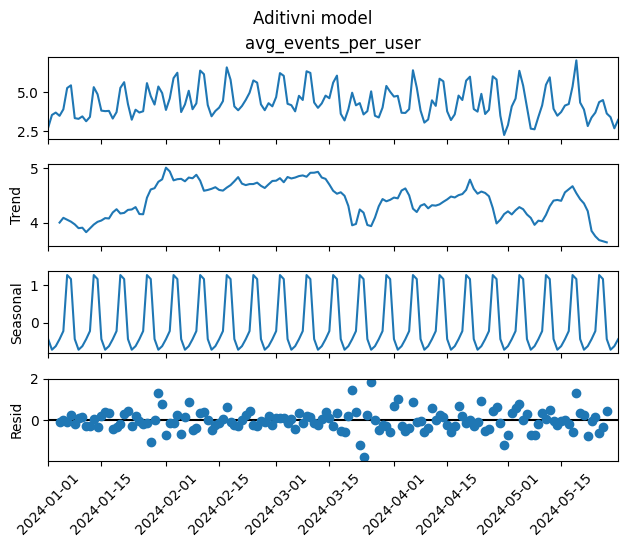

In [ ]:
result_add = seasonal_decompose(df['avg_events_per_user'], model='additive', period=7)
result_add.plot()
plt.suptitle("Aditivni model", y=1.02)
plt.xticks(rotation=45)
plt.show()

<Figure size 1500x800 with 0 Axes>

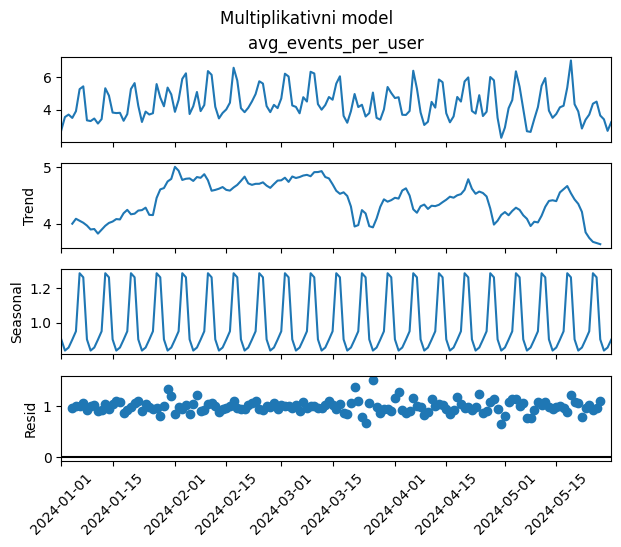

In [ ]:
result_add = seasonal_decompose(df['avg_events_per_user'], model='multiplicative', period=7)
plt.figure(figsize=(15, 8))
result_add.plot()
plt.suptitle("Multiplikativni model", y=1.02)
plt.xticks(rotation=45)
plt.show()

### STL

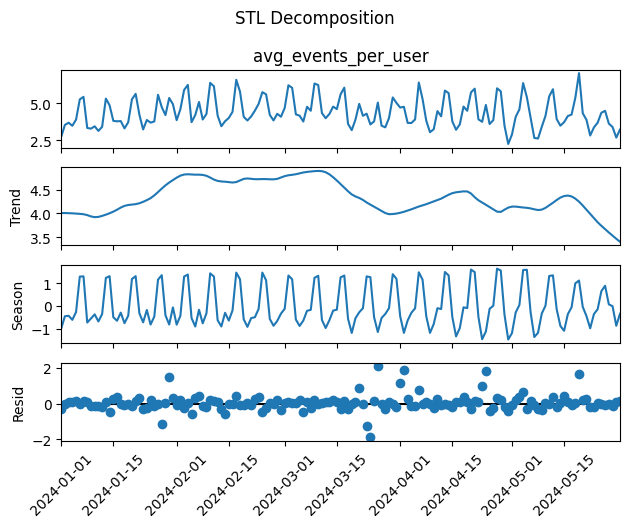

In [ ]:
stl = STL(df['avg_events_per_user'], seasonal=7, robust=True)
res = stl.fit()
res.plot()
plt.suptitle('STL Decomposition')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

For our data, classical decomposition seems more appropriate because the seasonal pattern is stable and consistent. The trend line is smoother with STL decomposition, which is expected since STL uses LOESS to smooth the curve.

## D) Check if data is stationary

### Unit Root Test

We are performing a unit root test to check for stationarity in the time series data. The unit root test helps determine whether a time series is non-stationary. If the p-value of the test is less than 0.05, we reject the null hypothesis (H0) of stationarity and conclude that differencing is needed.

H0: Data is stationary

In [ ]:
def kpss_test(series, regression='ct'):

    kpss_stat, p_value, _, critical_values = kpss(series.dropna(), regression=regression)

    print("KPSS Test Results:")
    print(f"Test Statistic: {kpss_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"  {key}: {value:.4f}")

    if p_value < 0.05:
        print("\nConclusion: Reject H0 → The series is not stationary.")
    else:
        print("\nConclusion: Fail to reject H0 → The series is stationary.")

    # Extra check using test statistic
    if kpss_stat > critical_values['5%']:
        print("\n(Stat-based check) Series is not stationary.")
    else:
        print("\n(Stat-based check) Series is stationary.")

In [ ]:
kpss_test(df['avg_events_per_user'])

KPSS Test Results:
Test Statistic: 0.1922
P-value: 0.0189
Critical Values:
  10%: 0.1190
  5%: 0.1460
  2.5%: 0.1760
  1%: 0.2160

Conclusion: Reject H0 → The series is not stationary.

(Stat-based check) Series is not stationary.


### Differencing

Considering the fact that the series is not stationary, we are going to use differencing to try to make non stationary series stationary.
For starters we will use first order differencing and add second order if needed.

In [ ]:
df['first_order_diff'] = df['avg_events_per_user'].diff()
df['first_order_diff'].fillna(method='bfill', inplace=True)

In [ ]:
kpss_test(df['first_order_diff'])

KPSS Test Results:
Test Statistic: 0.1900
P-value: 0.0198
Critical Values:
  10%: 0.1190
  5%: 0.1460
  2.5%: 0.1760
  1%: 0.2160

Conclusion: Reject H0 → The series is not stationary.

(Stat-based check) Series is not stationary.


In [ ]:
df['second_order_diff'] = df['first_order_diff'].diff()
df['second_order_diff'].fillna(method='bfill', inplace=True)

In [ ]:
kpss_test(df['second_order_diff'])

KPSS Test Results:
Test Statistic: 0.1377
P-value: 0.0654
Critical Values:
  10%: 0.1190
  5%: 0.1460
  2.5%: 0.1760
  1%: 0.2160

Conclusion: Fail to reject H0 → The series is stationary.

(Stat-based check) Series is stationary.


### ACF and PACF Plots

To determine the appropriate parameters for the ARIMA model, we first ensured the series was stationary by applying a unit root test (KPSS) and differencing. Following this, we will now examine the autocorrelation (ACF) and partial autocorrelation (PACF) plots to identify the values of p, d, and q for the ARIMA model. These plots will help us understand the dependence structure in the time series, guiding us in selecting the appropriate parameters.

- d (order of differencing): Determined by the number of times differencing was applied to achieve stationarity => 2

- p (AR order): Identified by observing the PACF plot. We looked for the lag after which the PACF drops off significantly  => 7

- q (MA order): Based on the ACF plot. We selected the lag after which the ACF values fall within the confidence interval => 8


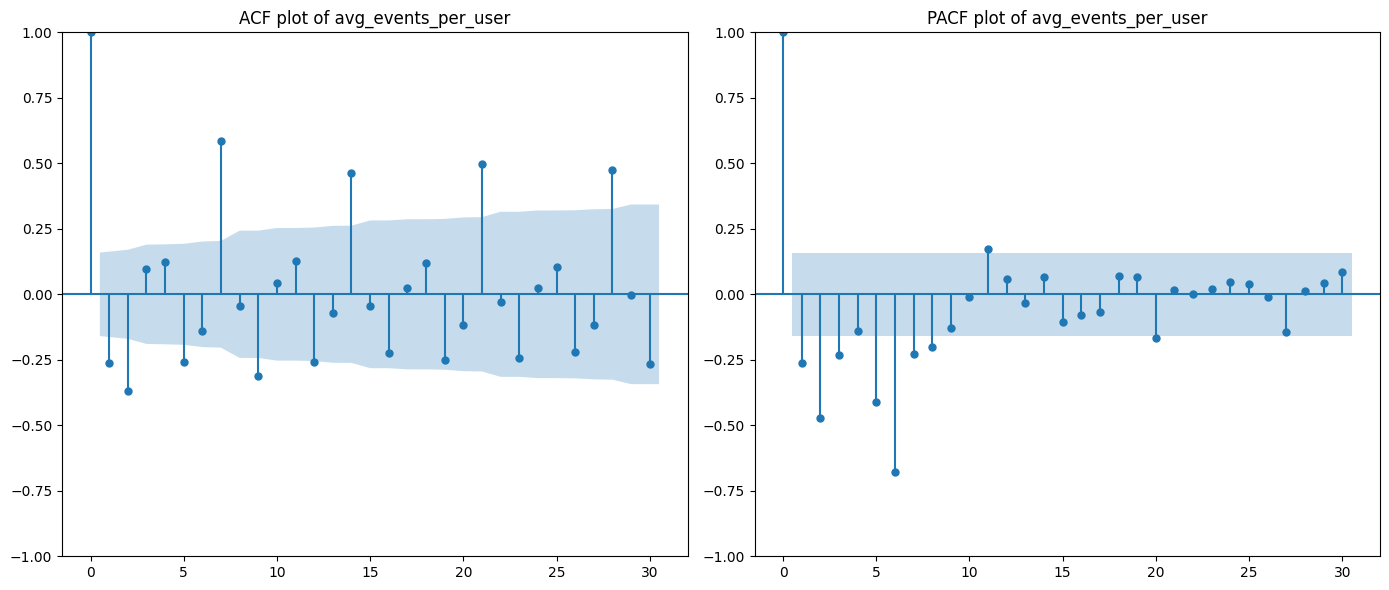

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_acf(df['second_order_diff'].dropna(), lags=30, ax=axes[0])
axes[0].set_title('ACF plot of avg_events_per_user')

plot_pacf(df['second_order_diff'].dropna(), lags=30, ax=axes[1])
axes[1].set_title('PACF plot of avg_events_per_user')

plt.tight_layout()
plt.show()

## E) Forecasting

In [ ]:
df.reset_index(inplace=True)

In [ ]:
train_df = df[(df['ev_date'] >= '2024-01-01') & (df['ev_date'] <= '2024-05-15')]
test_df = df[(df['ev_date'] >= '2024-05-16') & (df['ev_date'] <= '2024-05-30')]

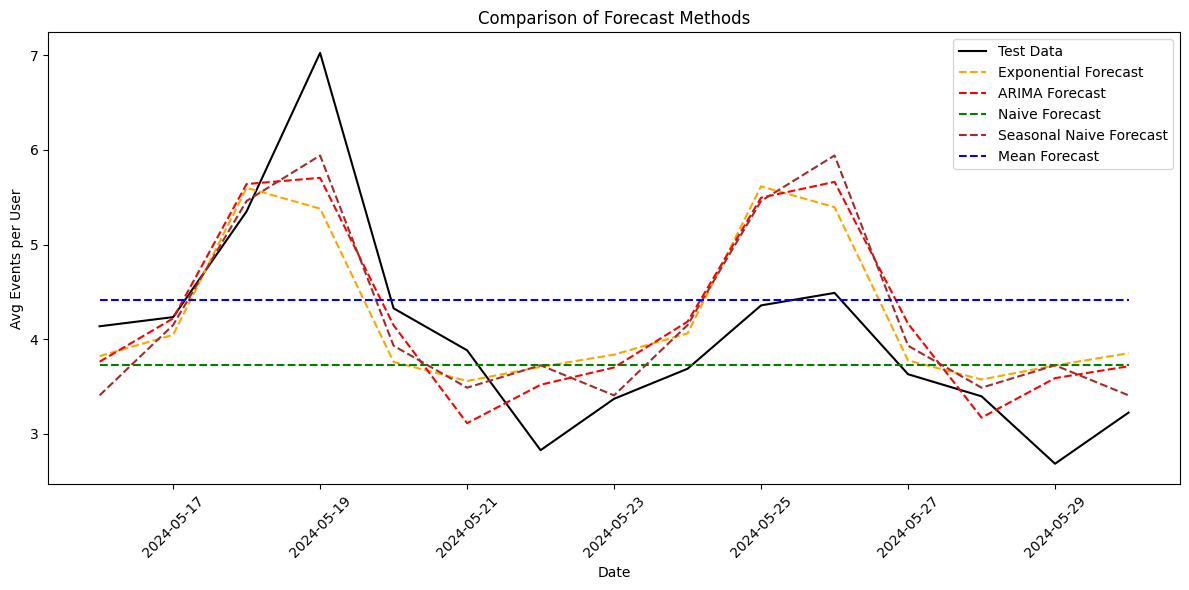

In [ ]:
naive_forecast = [train_df['avg_events_per_user'].iloc[-1]] * len(test_df)

seasonal_naive_forecast = np.tile(train_df['avg_events_per_user'].iloc[-7:].values, int(np.ceil(len(test_df)/7)))[:len(test_df)]

mean_forecast = [train_df['avg_events_per_user'].mean()] * len(test_df)

model = ExponentialSmoothing(train_df['avg_events_per_user'], trend='add', seasonal='add', seasonal_periods=7)
model_fit = model.fit()
forecast = model_fit.forecast(len(test_df))

arima_model = ARIMA(train_df['avg_events_per_user'], order=(7, 2, 8))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test_df))


plt.figure(figsize=(12, 6))
plt.plot(test_df['ev_date'], test_df['avg_events_per_user'], label='Test Data', color='black')
plt.plot(test_df['ev_date'], forecast, label='Exponential Forecast', color='orange', linestyle='--')
plt.plot(test_df['ev_date'], arima_forecast, label='ARIMA Forecast', color='red', linestyle='--')
plt.plot(test_df['ev_date'], naive_forecast, label='Naive Forecast', color='green', linestyle='--')
plt.plot(test_df['ev_date'], seasonal_naive_forecast, label='Seasonal Naive Forecast', color='brown', linestyle='--')
plt.plot(test_df['ev_date'], mean_forecast, label='Mean Forecast', color='blue', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Avg Events per User')
plt.title('Comparison of Forecast Methods')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
test_values = test_df['avg_events_per_user'].values

naive_mae = mean_absolute_error(test_values, naive_forecast)
naive_rmse = np.sqrt(mean_squared_error(test_values, naive_forecast))

seasonal_naive_mae = mean_absolute_error(test_values, seasonal_naive_forecast)
seasonal_naive_rmse = np.sqrt(mean_squared_error(test_values, seasonal_naive_forecast))

mean_mae = mean_absolute_error(test_values, mean_forecast)
mean_rmse = np.sqrt(mean_squared_error(test_values, mean_forecast))

model_mae = mean_absolute_error(test_values, forecast)
model_rmse = np.sqrt(mean_squared_error(test_values, forecast))

arima_mae = mean_absolute_error(test_values, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test_values, arima_forecast))

print(f"Naive Forecast - MAE: {naive_mae:.2f}, RMSE: {naive_rmse:.2f}")
print(f"Seasonal Naive Forecast - MAE: {seasonal_naive_mae:.2f}, RMSE: {seasonal_naive_rmse:.2f}")
print(f"Mean Forecast - MAE: {mean_mae:.2f}, RMSE: {mean_rmse:.2f}")
print(f"Exponential Smoothing Forecast - MAE: {model_mae:.2f}, RMSE: {model_rmse:.2f}")
print(f"ARIMA Forecast - MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}")

Naive Forecast - MAE: 0.75, RMSE: 1.09
Seasonal Naive Forecast - MAE: 0.56, RMSE: 0.71
Mean Forecast - MAE: 0.85, RMSE: 1.10
Exponential Smoothing Forecast - MAE: 0.61, RMSE: 0.75
ARIMA Forecast - MAE: 0.60, RMSE: 0.71


# Task 2

In [ ]:
forecast_dates = test_df['ev_date'].values
last_week_train = train_df['avg_events_per_user'].iloc[-7:].mean()
forecast_df = pd.DataFrame(columns=['date', 'forecast_method', 'forecast_value', 'wow_change'])

In [ ]:
arima_forecast = arima_forecast[:15].reset_index(drop=True)
forecast = forecast[:15].reset_index(drop=True)
test_values = test_df['avg_events_per_user'].values

In [ ]:
forecast_data = []

for i, date in enumerate(forecast_dates):
    # WoW promjena za prvi tjedan (u odnosu na stvarne vrijednosti)
    if i < 7:
        true_value = last_week_train  # Stvarni podaci iz prošlog tjedna
        naive_change = (naive_forecast[i] - true_value) / true_value
        seasonal_naive_change = (seasonal_naive_forecast[i] - true_value) / true_value
        mean_change = (mean_forecast[i] - true_value) / true_value
        exp_smoothing_change = (forecast[i] - true_value) / true_value
        arima_change = (arima_forecast[i] - true_value) / true_value
        test_change = (test_values[i] - true_value) / true_value
    else:
        # WoW promjena za ostatak tjedana (u odnosu na prošli tjedan predikcija)
        naive_change = (naive_forecast[i] - naive_forecast[i-7]) / naive_forecast[i-7]
        seasonal_naive_change = (seasonal_naive_forecast[i] - seasonal_naive_forecast[i-7]) / seasonal_naive_forecast[i-7]
        mean_change = (mean_forecast[i] - mean_forecast[i-7]) / mean_forecast[i-7]
        exp_smoothing_change = (forecast[i] - forecast[i-7]) / forecast[i-7]
        arima_change = (arima_forecast[i] - arima_forecast[i-7]) / arima_forecast[i-7]
        test_change = (test_values[i] - test_values[i-7]) / test_values[i-7]

    forecast_data.append({
        'date': date,
        'forecast_method': 'naive_forecast',
        'forecast_value': naive_forecast[i],
        'wow_change': naive_change
    })

    forecast_data.append({
        'date': date,
        'forecast_method': 'seasonal_naive_forecast',
        'forecast_value': seasonal_naive_forecast[i],
        'wow_change': seasonal_naive_change
    })

    forecast_data.append({
        'date': date,
        'forecast_method': 'mean_forecast',
        'forecast_value': mean_forecast[i],
        'wow_change': mean_change
    })

    forecast_data.append({
        'date': date,
        'forecast_method': 'exp_smoothing_forecast',
        'forecast_value': forecast[i],
        'wow_change': exp_smoothing_change
    })

    forecast_data.append({
        'date': date,
        'forecast_method': 'arima_forecast',
        'forecast_value': arima_forecast[i],
        'wow_change': arima_change
    })

    forecast_data.append({
        'date': date,
        'forecast_method': 'actual_values',
        'forecast_value': test_values[i],
        'wow_change': test_change
    })

forecast_df = pd.DataFrame(forecast_data)

In [ ]:
forecast_df.head(15)

,date,forecast_method,forecast_value,wow_change
0,2024-05-16,naive_forecast,3.724019,-0.133921
1,2024-05-16,seasonal_naive_forecast,3.406357,-0.207798
2,2024-05-16,mean_forecast,4.412252,0.026138
3,2024-05-16,exp_smoothing_forecast,3.821192,-0.111322
4,2024-05-16,arima_forecast,3.761554,-0.125192
5,2024-05-16,actual_values,4.136213,-0.038059
6,2024-05-17,naive_forecast,3.724019,-0.133921
7,2024-05-17,seasonal_naive_forecast,4.149307,-0.035014
8,2024-05-17,mean_forecast,4.412252,0.026138
9,2024-05-17,exp_smoothing_forecast,4.045684,-0.059113


In [ ]:
create_table_query = """
    CREATE TABLE IF NOT EXISTS lrunjic.forecast_results (
        date Date,
        forecast_method String,
        forecast_value Float64,
        wow_change Float64
    ) ENGINE = MergeTree()
    ORDER BY date
"""

In [ ]:
client.execute(create_table_query)

[]

In [ ]:
data_dict = forecast_df.to_dict(orient='records')

data_to_insert = [(row['date'], row['forecast_method'], row['forecast_value'], row['wow_change']) for row in data_dict]

insert_query = """
    INSERT INTO lrunjic.forecast_results (date, forecast_method, forecast_value, wow_change)
    VALUES
"""

client.execute(insert_query, data_to_insert)

90